# Introducing: 

## Source:
https://www.kaggle.com/datasets/ajay1735/hmeq-data

## Context: 
The consumer credit department of a bank wants to automate the decisionmaking process for approval of home equity lines of credit. To do this, they will follow the recommendations of the Equal Credit Opportunity Act to create an empirically derived and statistically sound credit scoring model. The model will be based on data collected from recent applicants granted credit through the current process of loan underwriting. The model will be built from predictive modeling tools, but the created model must be sufficiently interpretable to provide a reason for any adverse actions (rejections).

## Task: 
- predict default

## Used Libraries:
- pandas
- numpy
- matplotlib
- phik
- sklearn
- optuna
- xgboost
- catboost

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('dark_background')

import phik


#import warnings
#warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,r2_score,mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval
from sklearn.metrics import precision_recall_fscore_support as score


import optuna
from optuna.visualization.matplotlib import plot_param_importances


from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Data Preparation:

## Format Data

In [2]:
df = pd.read_csv('hmeq.csv')
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [3]:
df.columns = map(str.lower, df.columns)
df

,bad,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,89000,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,89200,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,89800,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


In [4]:
df.describe()

,bad,loan,mortdue,value,yoj,derog,delinq,clage,ninq,clno,debtinc
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   bad      5960 non-null   int64  
 1   loan     5960 non-null   int64  
 2   mortdue  5442 non-null   float64
 3   value    5848 non-null   float64
 4   reason   5708 non-null   object 
 5   job      5681 non-null   object 
 6   yoj      5445 non-null   float64
 7   derog    5252 non-null   float64
 8   delinq   5380 non-null   float64
 9   clage    5652 non-null   float64
 10  ninq     5450 non-null   float64
 11  clno     5738 non-null   float64
 12  debtinc  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [6]:
df['bad'].value_counts()

bad
0    4771
1    1189
Name: count, dtype: int64

<AxesSubplot:>

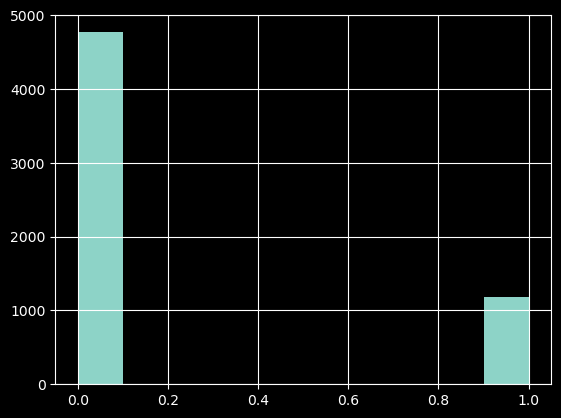

In [7]:
df['bad'].hist()

## Skips, Nans:

In [8]:
df.isna().mean().sort_values(ascending=False).reset_index()

,index,0
0,debtinc,0.212584
1,derog,0.118792
2,delinq,0.097315
3,mortdue,0.086913
4,yoj,0.086409
5,ninq,0.085570
6,clage,0.051678
7,job,0.046812
8,reason,0.042282
9,clno,0.037248


In [9]:
df['debtinc'] = df['debtinc'].fillna(df['debtinc'].median())

In [10]:
df['derog'] = df['derog'].fillna(df['derog'].median())

In [11]:
df['delinq'] = df['delinq'].fillna(df['delinq'].median())

In [12]:
df['mortdue'] = df['mortdue'].fillna(df['mortdue'].median())

In [13]:
df['yoj'] = df['yoj'].fillna(df['yoj'].median())

In [14]:
df['ninq'] = df['ninq'].fillna(df['ninq'].median())

In [15]:
df['clage'] = df['clage'].fillna(df['clage'].median())

In [16]:
df['job'] = df['job'].fillna('Other')

In [17]:
df['clno'] = df['clno'].fillna(df['clno'].median())

In [18]:
df['value'] = df['value'].fillna(df['clno'].median())

In [19]:
df['reason'] = df['reason'].map({'DebtCon' : 0, 'HomeImp' : 1})

In [20]:
df['reason'] = df['reason'].fillna(0)

In [21]:
df.isna().mean().sort_values(ascending=False).reset_index()

,index,0
0,bad,0.0
1,loan,0.0
2,mortdue,0.0
3,value,0.0
4,reason,0.0
5,job,0.0
6,yoj,0.0
7,derog,0.0
8,delinq,0.0
9,clage,0.0


## dtypes

In [22]:
df.dtypes

bad          int64
loan         int64
mortdue    float64
value      float64
reason     float64
job         object
yoj        float64
derog      float64
delinq     float64
clage      float64
ninq       float64
clno       float64
debtinc    float64
dtype: object

In [23]:
df['reason'].value_counts()

reason
0.0    4180
1.0    1780
Name: count, dtype: int64

In [24]:
df['job'].value_counts()

job
Other      2667
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: count, dtype: int64

# Quick Analysis

## Phik

In [25]:
phik_overview = df.phik_matrix()

interval columns not set, guessing: ['bad', 'loan', 'mortdue', 'value', 'reason', 'yoj', 'derog', 'delinq', 'clage', 'ninq', 'clno', 'debtinc']


In [26]:
phik_overview['bad'].sort_values(ascending=False).reset_index()

,index,bad
0,bad,1.000000
1,delinq,0.416037
2,derog,0.375744
3,ninq,0.234801
4,clno,0.174420
5,loan,0.157867
6,job,0.149454
7,clage,0.148381
8,debtinc,0.137918
9,yoj,0.123907


In [27]:
(phik_overview['bad'].sort_values(ascending=False).reset_index()
.style
.highlight_between(left=.3, right=1, subset='bad', color='red' )
.highlight_between(left=.1, right=.3, subset='bad', color='orange' )
.highlight_between(left=0, right=.1, subset='bad', color='green' )

.format({
    'bad': '{:,.2%}'.format,
})
)

,index,bad
0,bad,100.00%
1,delinq,41.60%
2,derog,37.57%
3,ninq,23.48%
4,clno,17.44%
5,loan,15.79%
6,job,14.95%
7,clage,14.84%
8,debtinc,13.79%
9,yoj,12.39%


In [28]:
df

,bad,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc
0,1,1100,25860.0,39025.0,1.0,Other,10.5,0.0,0.0,94.366667,1.0,9.0,34.818262
1,1,1300,70053.0,68400.0,1.0,Other,7.0,0.0,2.0,121.833333,0.0,14.0,34.818262
2,1,1500,13500.0,16700.0,1.0,Other,4.0,0.0,0.0,149.466667,1.0,10.0,34.818262
3,1,1500,65019.0,20.0,0.0,Other,7.0,0.0,0.0,173.466667,1.0,20.0,34.818262
4,0,1700,97800.0,112000.0,1.0,Office,3.0,0.0,0.0,93.333333,0.0,14.0,34.818262
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,0.0,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,89000,54576.0,92937.0,0.0,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,89200,54045.0,92924.0,0.0,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,89800,50370.0,91861.0,0.0,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


### delinq

In [29]:
df['delinq'].value_counts()

delinq
0.0     4759
1.0      654
2.0      250
3.0      129
4.0       78
5.0       38
6.0       27
7.0       13
8.0        5
10.0       2
11.0       2
15.0       1
12.0       1
13.0       1
Name: count, dtype: int64

<AxesSubplot:>

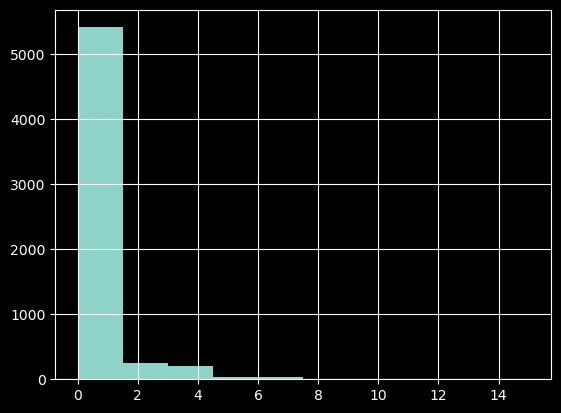

In [30]:
df['delinq'].hist()

In [31]:
df.groupby('delinq')['bad'].agg(['count', 'mean',])

,count,mean
delinq,,
0.0,4759,0.137634
1.0,654,0.339450
2.0,250,0.448000
3.0,129,0.550388
4.0,78,0.589744
5.0,38,0.815789
6.0,27,1.000000
7.0,13,1.000000
8.0,5,1.000000


In [32]:
(df.groupby(['delinq'])['bad']
.agg(['count', 'mean'])
.style
.highlight_between(left=.3, right=1, subset='mean', color='red' )
.highlight_between(left=.15, right=.4, subset='mean', color='orange' )
.highlight_between(left=0, right=.15, subset='mean', color='green' )

.format({
    'mean': '{:,.2%}'.format,
})
)

,count,mean
delinq,,
0.000000,4759,13.76%
1.000000,654,33.94%
2.000000,250,44.80%
3.000000,129,55.04%
4.000000,78,58.97%
5.000000,38,81.58%
6.000000,27,100.00%
7.000000,13,100.00%
8.000000,5,100.00%


### loan_group

In [33]:
df['loan_group'] = pd.qcut(df['loan'],5)

/tmp/ipykernel_26592/857377010.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('loan_group')['bad'].mean().plot(ylim=0, grid=True,kind='bar')


<AxesSubplot:xlabel='loan_group'>

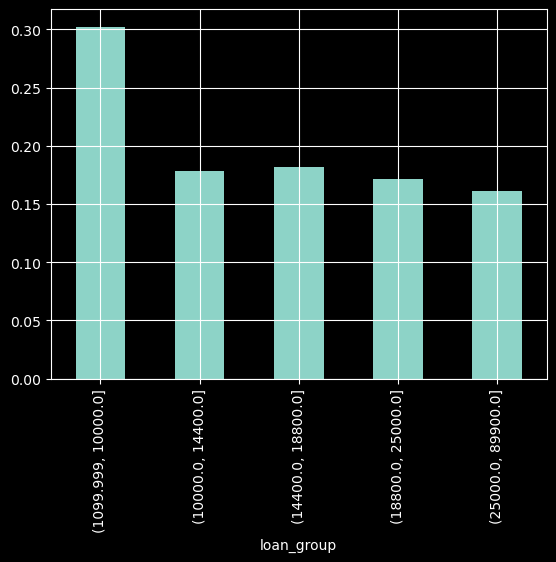

In [34]:
df.groupby('loan_group')['bad'].mean().plot(ylim=0, grid=True,kind='bar')

In [35]:
df.groupby('loan_group')['bad'].agg(['count', 'mean',])

/tmp/ipykernel_26592/71613134.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('loan_group')['bad'].agg(['count', 'mean',])


,count,mean
loan_group,,
"(1099.999, 10000.0]",1211,0.302230
"(10000.0, 14400.0]",1192,0.178691
"(14400.0, 18800.0]",1182,0.181895
"(18800.0, 25000.0]",1204,0.171096
"(25000.0, 89900.0]",1171,0.161401


### derog

In [36]:
df['derog'].value_counts()

derog
0.0     5235
1.0      435
2.0      160
3.0       58
4.0       23
5.0       15
6.0       15
7.0        8
8.0        6
9.0        3
10.0       2
Name: count, dtype: int64

<AxesSubplot:>

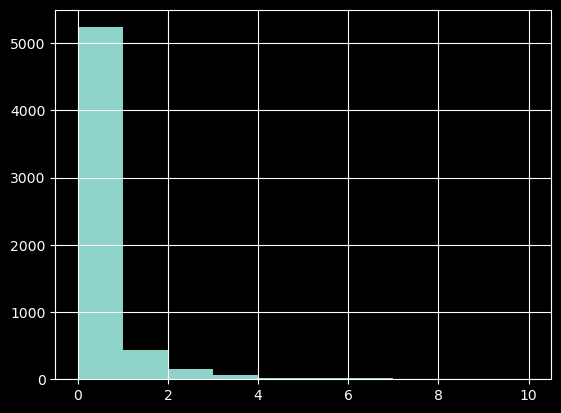

In [37]:
df['derog'].hist()

In [38]:
df.groupby('derog')['bad'].agg(['count', 'mean',])

,count,mean
derog,,
0.0,5235,0.160649
1.0,435,0.388506
2.0,160,0.512500
3.0,58,0.741379
4.0,23,0.782609
5.0,15,0.466667
6.0,15,0.666667
7.0,8,1.000000
8.0,6,1.000000


In [39]:
(df.groupby(['derog'])['bad']
.agg(['count', 'mean'])
.style
.highlight_between(left=.3, right=1, subset='mean', color='red' )
.highlight_between(left=.15, right=.4, subset='mean', color='orange' )
.highlight_between(left=0, right=.15, subset='mean', color='green' )

.format({
    'mean': '{:,.2%}'.format,
})
)

,count,mean
derog,,
0.000000,5235,16.06%
1.000000,435,38.85%
2.000000,160,51.25%
3.000000,58,74.14%
4.000000,23,78.26%
5.000000,15,46.67%
6.000000,15,66.67%
7.000000,8,100.00%
8.000000,6,100.00%


### ninq

In [40]:
df['ninq'].value_counts()

ninq
0.0     2531
1.0     1849
2.0      780
3.0      392
4.0      156
5.0       75
6.0       56
7.0       44
10.0      28
8.0       22
9.0       11
11.0      10
12.0       2
13.0       2
14.0       1
17.0       1
Name: count, dtype: int64

<AxesSubplot:>

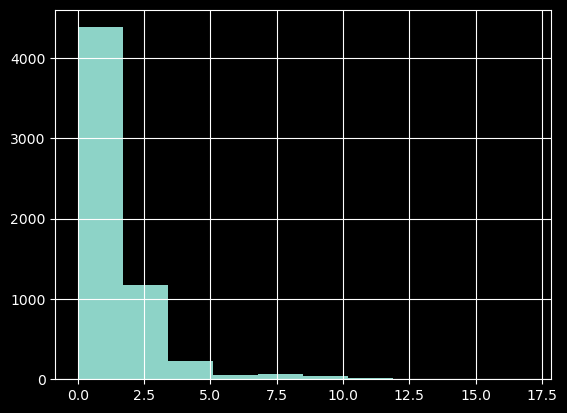

In [41]:
df['ninq'].hist()

In [42]:
df.groupby('ninq')['bad'].agg(['count', 'mean',])

,count,mean
ninq,,
0.0,2531,0.156460
1.0,1849,0.177934
2.0,780,0.232051
3.0,392,0.272959
4.0,156,0.391026
5.0,75,0.480000
6.0,56,0.517857
7.0,44,0.340909
8.0,22,0.500000


In [43]:
(df.groupby(['ninq'])['bad']
.agg(['count', 'mean'])
.style
.highlight_between(left=.3, right=1, subset='mean', color='red' )
.highlight_between(left=.15, right=.4, subset='mean', color='orange' )
.highlight_between(left=0, right=.15, subset='mean', color='green' )

.format({
    'mean': '{:,.2%}'.format,
})
)

,count,mean
ninq,,
0.000000,2531,15.65%
1.000000,1849,17.79%
2.000000,780,23.21%
3.000000,392,27.30%
4.000000,156,39.10%
5.000000,75,48.00%
6.000000,56,51.79%
7.000000,44,34.09%
8.000000,22,50.00%


### clno

In [44]:
df['clno'].value_counts()

clno
20.0    453
16.0    316
19.0    307
24.0    264
23.0    259
       ... 
65.0      3
53.0      2
71.0      2
63.0      1
57.0      1
Name: count, Length: 62, dtype: int64

In [45]:
df['clno_group'] = pd.qcut(df['loan'],8)

/tmp/ipykernel_26592/1236209776.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('clno_group')['bad'].mean().plot(ylim=0, grid=True,kind='bar')


<AxesSubplot:xlabel='clno_group'>

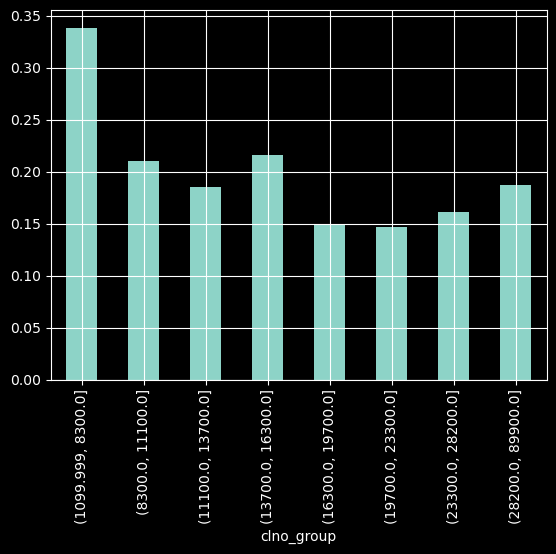

In [46]:
df.groupby('clno_group')['bad'].mean().plot(ylim=0, grid=True,kind='bar')

In [47]:
df.groupby('clno_group')['bad'].agg(['count', 'mean',])

/tmp/ipykernel_26592/1128469648.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('clno_group')['bad'].agg(['count', 'mean',])


,count,mean
clno_group,,
"(1099.999, 8300.0]",759,0.338603
"(8300.0, 11100.0]",757,0.210040
"(11100.0, 13700.0]",729,0.185185
"(13700.0, 16300.0]",736,0.216033
"(16300.0, 19700.0]",752,0.148936
"(19700.0, 23300.0]",744,0.146505
"(23300.0, 28200.0]",745,0.161074
"(28200.0, 89900.0]",738,0.186992


In [48]:
(df.groupby(['clno_group'])['bad']
.agg(['count', 'mean'])
.style
.highlight_between(left=.3, right=1, subset='mean', color='red' )
.highlight_between(left=.15, right=.3, subset='mean', color='orange' )
.highlight_between(left=0, right=.15, subset='mean', color='green' )

.format({
    'mean': '{:,.2%}'.format,
})
)

/tmp/ipykernel_26592/1494949934.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (df.groupby(['clno_group'])['bad']


,count,mean
clno_group,,
"(1099.999, 8300.0]",759,33.86%
"(8300.0, 11100.0]",757,21.00%
"(11100.0, 13700.0]",729,18.52%
"(13700.0, 16300.0]",736,21.60%
"(16300.0, 19700.0]",752,14.89%
"(19700.0, 23300.0]",744,14.65%
"(23300.0, 28200.0]",745,16.11%
"(28200.0, 89900.0]",738,18.70%


# Features Engineering:

In [49]:
df

,bad,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc,loan_group,clno_group
0,1,1100,25860.0,39025.0,1.0,Other,10.5,0.0,0.0,94.366667,1.0,9.0,34.818262,"(1099.999, 10000.0]","(1099.999, 8300.0]"
1,1,1300,70053.0,68400.0,1.0,Other,7.0,0.0,2.0,121.833333,0.0,14.0,34.818262,"(1099.999, 10000.0]","(1099.999, 8300.0]"
2,1,1500,13500.0,16700.0,1.0,Other,4.0,0.0,0.0,149.466667,1.0,10.0,34.818262,"(1099.999, 10000.0]","(1099.999, 8300.0]"
3,1,1500,65019.0,20.0,0.0,Other,7.0,0.0,0.0,173.466667,1.0,20.0,34.818262,"(1099.999, 10000.0]","(1099.999, 8300.0]"
4,0,1700,97800.0,112000.0,1.0,Office,3.0,0.0,0.0,93.333333,0.0,14.0,34.818262,"(1099.999, 10000.0]","(1099.999, 8300.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,0.0,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347,"(25000.0, 89900.0]","(28200.0, 89900.0]"
5956,0,89000,54576.0,92937.0,0.0,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971,"(25000.0, 89900.0]","(28200.0, 89900.0]"
5957,0,89200,54045.0,92924.0,0.0,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590,"(25000.0, 89900.0]","(28200.0, 89900.0]"
5958,0,89800,50370.0,91861.0,0.0,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882,"(25000.0, 89900.0]","(28200.0, 89900.0]"


In [50]:
df.drop('loan_group', axis=1, inplace=True)

In [51]:
df.drop('clno_group', axis=1, inplace=True)

In [52]:
df

,bad,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc
0,1,1100,25860.0,39025.0,1.0,Other,10.5,0.0,0.0,94.366667,1.0,9.0,34.818262
1,1,1300,70053.0,68400.0,1.0,Other,7.0,0.0,2.0,121.833333,0.0,14.0,34.818262
2,1,1500,13500.0,16700.0,1.0,Other,4.0,0.0,0.0,149.466667,1.0,10.0,34.818262
3,1,1500,65019.0,20.0,0.0,Other,7.0,0.0,0.0,173.466667,1.0,20.0,34.818262
4,0,1700,97800.0,112000.0,1.0,Office,3.0,0.0,0.0,93.333333,0.0,14.0,34.818262
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,0.0,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,89000,54576.0,92937.0,0.0,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,89200,54045.0,92924.0,0.0,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,89800,50370.0,91861.0,0.0,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


## Convert categorical variables into numerical

In [53]:
df.dtypes

bad          int64
loan         int64
mortdue    float64
value      float64
reason     float64
job         object
yoj        float64
derog      float64
delinq     float64
clage      float64
ninq       float64
clno       float64
debtinc    float64
dtype: object

### job

In [54]:
df['job'].value_counts()

job
Other      2667
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: count, dtype: int64

In [55]:
pd.get_dummies(df['job'],prefix='job')

,job_Mgr,job_Office,job_Other,job_ProfExe,job_Sales,job_Self
0,False,False,True,False,False,False
1,False,False,True,False,False,False
2,False,False,True,False,False,False
3,False,False,True,False,False,False
4,False,True,False,False,False,False
...,...,...,...,...,...,...
5955,False,False,True,False,False,False
5956,False,False,True,False,False,False
5957,False,False,True,False,False,False
5958,False,False,True,False,False,False


In [56]:
df_dum =pd.get_dummies(df['job'],prefix='job')
df_dum

,job_Mgr,job_Office,job_Other,job_ProfExe,job_Sales,job_Self
0,False,False,True,False,False,False
1,False,False,True,False,False,False
2,False,False,True,False,False,False
3,False,False,True,False,False,False
4,False,True,False,False,False,False
...,...,...,...,...,...,...
5955,False,False,True,False,False,False
5956,False,False,True,False,False,False
5957,False,False,True,False,False,False
5958,False,False,True,False,False,False


In [57]:
df_dum.columns = ['job_mgr', 'job_office', 'job_other', 'job_prof_exe', 'job_sales',
       'job_self']

In [58]:
df_dum

,job_mgr,job_office,job_other,job_prof_exe,job_sales,job_self
0,False,False,True,False,False,False
1,False,False,True,False,False,False
2,False,False,True,False,False,False
3,False,False,True,False,False,False
4,False,True,False,False,False,False
...,...,...,...,...,...,...
5955,False,False,True,False,False,False
5956,False,False,True,False,False,False
5957,False,False,True,False,False,False
5958,False,False,True,False,False,False


In [59]:
df = pd.concat([df,df_dum],axis=1)
df

,bad,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc,job_mgr,job_office,job_other,job_prof_exe,job_sales,job_self
0,1,1100,25860.0,39025.0,1.0,Other,10.5,0.0,0.0,94.366667,1.0,9.0,34.818262,False,False,True,False,False,False
1,1,1300,70053.0,68400.0,1.0,Other,7.0,0.0,2.0,121.833333,0.0,14.0,34.818262,False,False,True,False,False,False
2,1,1500,13500.0,16700.0,1.0,Other,4.0,0.0,0.0,149.466667,1.0,10.0,34.818262,False,False,True,False,False,False
3,1,1500,65019.0,20.0,0.0,Other,7.0,0.0,0.0,173.466667,1.0,20.0,34.818262,False,False,True,False,False,False
4,0,1700,97800.0,112000.0,1.0,Office,3.0,0.0,0.0,93.333333,0.0,14.0,34.818262,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,0.0,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347,False,False,True,False,False,False
5956,0,89000,54576.0,92937.0,0.0,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971,False,False,True,False,False,False
5957,0,89200,54045.0,92924.0,0.0,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590,False,False,True,False,False,False
5958,0,89800,50370.0,91861.0,0.0,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882,False,False,True,False,False,False


In [60]:
df.drop('job', axis=1, inplace=True)

In [61]:
df.dtypes

bad               int64
loan              int64
mortdue         float64
value           float64
reason          float64
yoj             float64
derog           float64
delinq          float64
clage           float64
ninq            float64
clno            float64
debtinc         float64
job_mgr            bool
job_office         bool
job_other          bool
job_prof_exe       bool
job_sales          bool
job_self           bool
dtype: object

## Define X and y:

In [62]:
X = df.drop("bad", axis = 1)
y = df["bad"]

In [63]:
X

,loan,mortdue,value,reason,yoj,derog,delinq,clage,ninq,clno,debtinc,job_mgr,job_office,job_other,job_prof_exe,job_sales,job_self
0,1100,25860.0,39025.0,1.0,10.5,0.0,0.0,94.366667,1.0,9.0,34.818262,False,False,True,False,False,False
1,1300,70053.0,68400.0,1.0,7.0,0.0,2.0,121.833333,0.0,14.0,34.818262,False,False,True,False,False,False
2,1500,13500.0,16700.0,1.0,4.0,0.0,0.0,149.466667,1.0,10.0,34.818262,False,False,True,False,False,False
3,1500,65019.0,20.0,0.0,7.0,0.0,0.0,173.466667,1.0,20.0,34.818262,False,False,True,False,False,False
4,1700,97800.0,112000.0,1.0,3.0,0.0,0.0,93.333333,0.0,14.0,34.818262,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,88900,57264.0,90185.0,0.0,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347,False,False,True,False,False,False
5956,89000,54576.0,92937.0,0.0,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971,False,False,True,False,False,False
5957,89200,54045.0,92924.0,0.0,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590,False,False,True,False,False,False
5958,89800,50370.0,91861.0,0.0,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882,False,False,True,False,False,False


In [64]:
y

0       1
1       1
2       1
3       1
4       0
       ..
5955    0
5956    0
5957    0
5958    0
5959    0
Name: bad, Length: 5960, dtype: int64

## Split the datasets into train and test sets:
- train 80%
- test 20%

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [66]:
len(X_train) / len(df)

0.8

In [67]:
len(X_test) / len(df)

0.2

In [68]:
X_train.dtypes

loan              int64
mortdue         float64
value           float64
reason          float64
yoj             float64
derog           float64
delinq          float64
clage           float64
ninq            float64
clno            float64
debtinc         float64
job_mgr            bool
job_office         bool
job_other          bool
job_prof_exe       bool
job_sales          bool
job_self           bool
dtype: object

In [69]:
X_train

,loan,mortdue,value,reason,yoj,derog,delinq,clage,ninq,clno,debtinc,job_mgr,job_office,job_other,job_prof_exe,job_sales,job_self
944,9100,62976.0,77829.0,1.0,0.0,0.0,2.0,131.193496,0.0,23.0,26.090419,True,False,False,False,False,False
5755,43800,5884.0,64890.0,1.0,7.0,0.0,0.0,309.827548,0.0,19.0,16.160451,False,True,False,False,False,False
2259,13800,75142.0,95667.0,0.0,19.0,0.0,0.0,230.457554,10.0,24.0,33.383314,True,False,False,False,False,False
12,2000,45000.0,55000.0,1.0,3.0,0.0,0.0,86.066667,2.0,25.0,34.818262,False,False,True,False,False,False
1117,9900,47367.0,114837.0,0.0,4.0,0.0,0.0,210.435534,0.0,10.0,25.042109,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,20000,99300.0,139150.0,1.0,10.0,0.0,0.0,162.366667,1.0,23.0,34.818262,False,False,False,True,False,False
5191,28000,49764.0,74526.0,0.0,24.0,0.0,1.0,294.594783,1.0,30.0,37.611309,False,False,True,False,False,False
5226,28300,71973.0,119224.0,0.0,4.0,0.0,0.0,89.379952,2.0,32.0,39.981059,False,False,True,False,False,False
5390,31100,73386.0,108864.0,1.0,5.0,0.0,0.0,119.539518,10.0,21.0,42.826601,False,False,True,False,False,False


In [70]:
y_train

944     0
5755    0
2259    0
12      1
1117    0
       ..
3772    0
5191    0
5226    0
5390    0
860     0
Name: bad, Length: 4768, dtype: int64

## Standardization:

In [71]:
X_train.describe()

,loan,mortdue,value,reason,yoj,derog,delinq,clage,ninq,clno,debtinc
count,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000
mean,18609.416946,73099.154690,100107.559767,0.297609,8.773962,0.224832,0.381921,179.523315,1.172399,21.213926,33.903136
std,11010.307042,42931.103573,58205.076446,0.457255,7.301785,0.789720,1.030022,84.469637,1.668844,9.902311,7.478155
min,1100.000000,2063.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,11200.000000,48080.000000,65398.750000,0.000000,3.000000,0.000000,0.000000,117.143808,0.000000,15.000000,30.619856
50%,16450.000000,65019.000000,88486.500000,0.000000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,23300.000000,88159.500000,118716.500000,1.000000,12.000000,0.000000,0.000000,227.827965,2.000000,26.000000,37.950779
max,89900.000000,399550.000000,855909.000000,1.000000,41.000000,10.000000,12.000000,1168.233561,17.000000,71.000000,144.189001


In [72]:
X_train

,loan,mortdue,value,reason,yoj,derog,delinq,clage,ninq,clno,debtinc,job_mgr,job_office,job_other,job_prof_exe,job_sales,job_self
944,9100,62976.0,77829.0,1.0,0.0,0.0,2.0,131.193496,0.0,23.0,26.090419,True,False,False,False,False,False
5755,43800,5884.0,64890.0,1.0,7.0,0.0,0.0,309.827548,0.0,19.0,16.160451,False,True,False,False,False,False
2259,13800,75142.0,95667.0,0.0,19.0,0.0,0.0,230.457554,10.0,24.0,33.383314,True,False,False,False,False,False
12,2000,45000.0,55000.0,1.0,3.0,0.0,0.0,86.066667,2.0,25.0,34.818262,False,False,True,False,False,False
1117,9900,47367.0,114837.0,0.0,4.0,0.0,0.0,210.435534,0.0,10.0,25.042109,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,20000,99300.0,139150.0,1.0,10.0,0.0,0.0,162.366667,1.0,23.0,34.818262,False,False,False,True,False,False
5191,28000,49764.0,74526.0,0.0,24.0,0.0,1.0,294.594783,1.0,30.0,37.611309,False,False,True,False,False,False
5226,28300,71973.0,119224.0,0.0,4.0,0.0,0.0,89.379952,2.0,32.0,39.981059,False,False,True,False,False,False
5390,31100,73386.0,108864.0,1.0,5.0,0.0,0.0,119.539518,10.0,21.0,42.826601,False,False,True,False,False,False


In [73]:
# Initiate scaler
sc = StandardScaler()

# Standardize the training dataset
X_train = pd.DataFrame(sc.fit_transform(X_train),index=X_train.index, columns=X_train.columns)

# Standardized the testing dataset
X_test = pd.DataFrame(sc.transform(X_test),index=X_test.index, columns=X_test.columns)

# Summary statistics after standardization
X_train.describe()

,loan,mortdue,value,reason,yoj,derog,delinq,clage,ninq,clno,debtinc,job_mgr,job_office,job_other,job_prof_exe,job_sales,job_self
count,4.768000e+03,4.768000e+03,4.768000e+03,4.768000e+03,4.768000e+03,4.768000e+03,4.768000e+03,4.768000e+03,4.768000e+03,4.768000e+03,4.768000e+03,4.768000e+03,4.768000e+03,4.768000e+03,4.768000e+03,4.768000e+03,4.768000e+03
mean,1.035711e-16,5.215813e-18,1.445525e-16,-1.710042e-16,-1.236893e-16,-1.490232e-17,-3.725581e-18,2.414176e-16,1.341209e-17,-1.315130e-16,-1.777102e-16,1.341209e-17,-3.762836e-17,-1.050614e-16,3.874604e-17,7.451161e-19,6.333487e-17
std,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00
min,-1.590442e+00,-1.654828e+00,-1.719748e+00,-6.509290e-01,-1.201745e+00,-2.847283e-01,-3.708284e-01,-2.125523e+00,-7.025955e-01,-2.142545e+00,-4.463954e+00,-3.866130e-01,-4.320417e-01,-8.966664e-01,-5.229764e-01,-1.402674e-01,-1.845237e-01
25%,-6.730234e-01,-5.828357e-01,-5.963818e-01,-6.509290e-01,-7.908433e-01,-2.847283e-01,-3.708284e-01,-7.385618e-01,-7.025955e-01,-6.275887e-01,-4.390955e-01,-3.866130e-01,-4.320417e-01,-8.966664e-01,-5.229764e-01,-1.402674e-01,-1.845237e-01
50%,-1.961474e-01,-1.882319e-01,-1.996781e-01,-6.509290e-01,-2.429745e-01,-2.847283e-01,-3.708284e-01,-7.170960e-02,-1.033155e-01,-1.226030e-01,1.223860e-01,-3.866130e-01,-4.320417e-01,-8.966664e-01,-5.229764e-01,-1.402674e-01,-1.845237e-01
75%,4.260621e-01,3.508395e-01,3.197469e-01,1.536266e+00,4.418613e-01,-2.847283e-01,-3.708284e-01,5.719181e-01,4.959645e-01,4.833797e-01,5.413190e-01,-3.866130e-01,-4.320417e-01,1.115242e+00,-5.229764e-01,-1.402674e-01,-1.845237e-01
max,6.475574e+00,7.604861e+00,1.298651e+01,1.536266e+00,4.413909e+00,1.237931e+01,1.128064e+01,1.170615e+01,9.485165e+00,5.028250e+00,1.474928e+01,2.586566e+00,2.314591e+00,1.115242e+00,1.912132e+00,7.129242e+00,5.419357e+00


In [74]:
X_train.dtypes

loan            float64
mortdue         float64
value           float64
reason          float64
yoj             float64
derog           float64
delinq          float64
clage           float64
ninq            float64
clno            float64
debtinc         float64
job_mgr         float64
job_office      float64
job_other       float64
job_prof_exe    float64
job_sales       float64
job_self        float64
dtype: object

In [75]:
X_train

,loan,mortdue,value,reason,yoj,derog,delinq,clage,ninq,clno,debtinc,job_mgr,job_office,job_other,job_prof_exe,job_sales,job_self
944,-0.863774,-0.235825,-0.382800,1.536266,-1.201745,-0.284728,1.571082,-0.572216,-0.702595,0.180388,-1.044848,2.586566,-0.432042,-0.896666,-0.522976,-0.140267,-0.184524
5755,2.288149,-1.565816,-0.605123,1.536266,-0.242975,-0.284728,-0.370828,1.542778,-0.702595,-0.223600,-2.372851,-0.386613,2.314591,-0.896666,-0.522976,-0.140267,-0.184524
2259,-0.436856,0.047589,-0.076300,-0.650929,1.400632,-0.284728,-0.370828,0.603052,5.290205,0.281385,-0.069519,2.586566,-0.432042,-0.896666,-0.522976,-0.140267,-0.184524
12,-1.508692,-0.654586,-0.775058,1.536266,-0.790843,-0.284728,-0.370828,-1.106509,0.495965,0.382383,0.122386,-0.386613,-0.432042,1.115242,-0.522976,-0.140267,-0.184524
1117,-0.791107,-0.599445,0.253088,-0.650929,-0.653876,-0.284728,-0.370828,0.365995,-0.702595,-1.132574,-1.185046,-0.386613,-0.432042,-0.896666,1.912132,-0.140267,-0.184524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,0.126312,0.610364,0.670844,1.536266,0.167927,-0.284728,-0.370828,-0.203132,-0.103315,0.180388,0.122386,-0.386613,-0.432042,-0.896666,1.912132,-0.140267,-0.184524
5191,0.852980,-0.543606,-0.439553,-0.650929,2.085467,-0.284728,0.600127,1.362425,-0.103315,0.887368,0.495919,-0.386613,-0.432042,1.115242,-0.522976,-0.140267,-0.184524
5226,0.880230,-0.026234,0.328467,-0.650929,-0.653876,-0.284728,-0.370828,-1.067281,0.495965,1.089362,0.812842,-0.386613,-0.432042,1.115242,-0.522976,-0.140267,-0.184524
5390,1.134564,0.006682,0.150457,1.536266,-0.516909,-0.284728,-0.370828,-0.710197,5.290205,-0.021606,1.193396,-0.386613,-0.432042,1.115242,-0.522976,-0.140267,-0.184524


# XGBoost:

## XGBoost default params:

In [76]:
xgb_model_1 = XGBClassifier()

In [77]:
%%time

xgb_model_1.fit(
          X_train,
          y_train,
          eval_set=[(X_test, y_test)],
)

[0]	validation_0-logloss:0.41898
[1]	validation_0-logloss:0.36614
[2]	validation_0-logloss:0.33353
[3]	validation_0-logloss:0.31357
[4]	validation_0-logloss:0.29617
[5]	validation_0-logloss:0.28837
[6]	validation_0-logloss:0.27551
[7]	validation_0-logloss:0.26725
[8]	validation_0-logloss:0.26037
[9]	validation_0-logloss:0.25793
[10]	validation_0-logloss:0.25171
[11]	validation_0-logloss:0.24818
[12]	validation_0-logloss:0.24454
[13]	validation_0-logloss:0.24258
[14]	validation_0-logloss:0.24105
[15]	validation_0-logloss:0.23783
[16]	validation_0-logloss:0.23087
[17]	validation_0-logloss:0.22916
[18]	validation_0-logloss:0.22709
[19]	validation_0-logloss:0.22138
[20]	validation_0-logloss:0.22106
[21]	validation_0-logloss:0.21833
[22]	validation_0-logloss:0.21583
[23]	validation_0-logloss:0.21572
[24]	validation_0-logloss:0.21437
[25]	validation_0-logloss:0.21378
[26]	validation_0-logloss:0.20943
[27]	validation_0-logloss:0.20958
[28]	validation_0-logloss:0.20816
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [78]:
y_pred1 = xgb_model_1.predict(X_test)

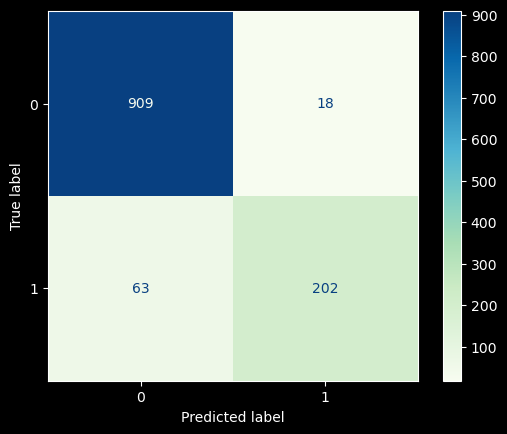

In [79]:
ConfusionMatrixDisplay.from_estimator(xgb_model_1, X_test, y_test, cmap='GnBu')
plt.show()

In [80]:
print('Precision: %.3f' % precision_score(y_test, y_pred1))
print('Recall: %.3f' % recall_score(y_test, y_pred1))
print('F1: %.3f' % f1_score(y_test, y_pred1))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred1))

Precision: 0.918
Recall: 0.762
F1: 0.833
Accuracy: 0.932


## XGBoost grid_search

In [81]:
xgb_model_2 = XGBClassifier()

In [82]:
gbm_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators':[200],
    'subsample':[0.3, 0.5, 0.8],
}

In [83]:
grid_search = GridSearchCV(
    estimator=xgb_model_2,
    param_grid=gbm_param_grid,
    scoring='recall',
    cv=5,
    verbose=1    
)

In [84]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [200], 'subsample': [0.3, 0.5, 0.8]},
             scoring='recall', verbose=1)

In [85]:
print(f'The best score is {grid_search.best_score_:.4f}')
print(f'The best hyperparameters are {grid_search.best_params_}')

The best score is 0.7078
The best hyperparameters are {'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.8}


In [86]:
# Make prediction using the best model
grid_predict = grid_search.predict(X_test)
# Get predicted probabilities
grid_predict_prob = grid_search.predict_proba(X_test)[:,1]

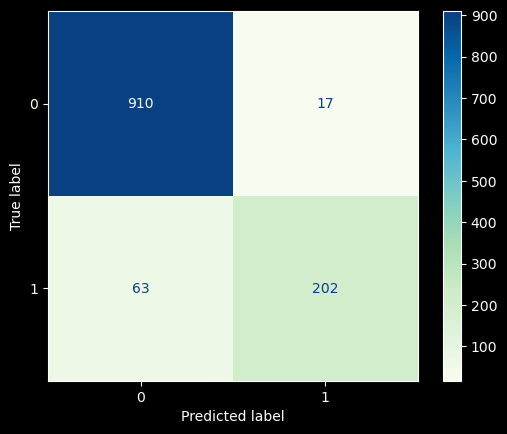

In [87]:
ConfusionMatrixDisplay.from_estimator(grid_search, X_test, y_test, cmap='GnBu')
plt.show()

In [88]:
print('Precision: %.3f' % precision_score(y_test, grid_predict))
print('Recall: %.3f' % recall_score(y_test, grid_predict))
print('F1: %.3f' % f1_score(y_test, grid_predict))
print('Accuracy: %.3f' % accuracy_score(y_test, grid_predict))

Precision: 0.922
Recall: 0.762
F1: 0.835
Accuracy: 0.933


## XGBoost random_search

In [89]:
xgb_model_3 = XGBClassifier()

In [90]:
gbm_param_grid = {
    'learning_rate': np.arange(0.01, 0.05, 0.1),
    'n_estimators':[200],
    'subsample':np.arange(0.3, 0.5, 0.8),
}

In [91]:
random_search = RandomizedSearchCV(
    estimator=xgb_model_3,
    param_distributions=gbm_param_grid,
    n_iter=20,
    scoring='recall',
    cv=5,
    verbose=1    
)

In [92]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/antonius/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=20,
                   param_distributions={'learning_rate': array([0.01]),
                                        'n_estimators': [200],
                                        'subsample': array([0.3])},
                   scoring='recall', verbose=1)

In [93]:
print(f'The best score is {random_search.best_score_:.4f}')
print(f'The best hyperparameters are {random_search.best_params_}')

The best score is 0.5519
The best hyperparameters are {'subsample': 0.3, 'n_estimators': 200, 'learning_rate': 0.01}


In [94]:
# Make prediction using the best model
random_predict = random_search.predict(X_test)
# Get predicted probabilities
random_predict_prob = random_search.predict_proba(X_test)[:,1]

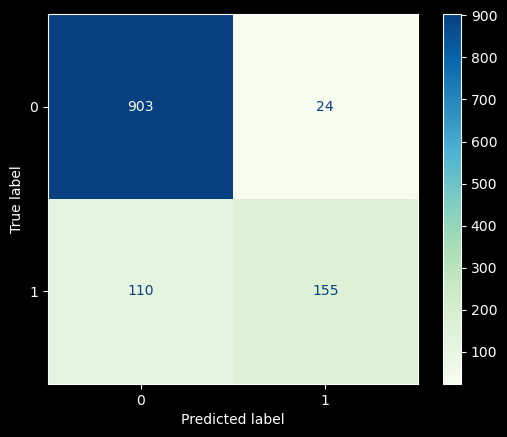

In [95]:
ConfusionMatrixDisplay.from_estimator(random_search, X_test, y_test, cmap='GnBu')
plt.show()

In [96]:
print('Precision: %.3f' % precision_score(y_test, random_predict))
print('Recall: %.3f' % recall_score(y_test, random_predict))
print('F1: %.3f' % f1_score(y_test, random_predict))
print('Accuracy: %.3f' % accuracy_score(y_test, random_predict))

Precision: 0.866
Recall: 0.585
F1: 0.698
Accuracy: 0.888


## XGBoost Bayesian Optimization

In [97]:
space = {
    'learning_rate': hp.choice('learning_rate', [0.0001,0.001, 0.01, 0.1, 1]),
    'max_depth' : hp.choice('max_depth', range(3,21,3)),
    'gamma' : hp.choice('gamma', [i/10.0 for i in range(0,5)]),
    'colsample_bytree' : hp.choice('colsample_bytree', [i/10.0 for i in range(3,10)]),     
    'reg_alpha' : hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 10, 100]), 
    'reg_lambda' : hp.choice('reg_lambda', [1e-5, 1e-2, 0.1, 1, 10, 100])
}

In [98]:
# Set up the k-fold cross-validation
kfold = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=0)

In [99]:
# Objective function
def objective(params):
    
    xgboost = XGBClassifier(seed=42, **params)
    score = cross_val_score(estimator=xgboost, 
                            X=X_train, 
                            y=y_train, 
                            cv=kfold, 
                            scoring='recall', 
                            n_jobs=-1).mean()

    # Loss is negative score
    loss = - score

    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [100]:
# Optimize
best = fmin(
    fn = objective,
    space = space,
    algo = tpe.suggest,
    max_evals = 48,
    trials = Trials())

100%|████████| 48/48 [00:16<00:00,  2.96trial/s, best loss: -0.6742424242424242]


In [101]:
# Print the index of the best parameters
print(best)

# Print the values of the best parameters
print(space_eval(space, best))

{'colsample_bytree': 4, 'gamma': 3, 'learning_rate': 3, 'max_depth': 5, 'reg_alpha': 2, 'reg_lambda': 3}
{'colsample_bytree': 0.7, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 18, 'reg_alpha': 0.1, 'reg_lambda': 1}


In [102]:
# Train model using the best parameters
xgboost_bo = XGBClassifier(seed=0, 
                           colsample_bytree=space_eval(space, best)['colsample_bytree'], 
                           gamma=space_eval(space, best)['gamma'], 
                           learning_rate=space_eval(space, best)['learning_rate'], 
                           max_depth=space_eval(space, best)['max_depth'], 
                           reg_alpha=space_eval(space, best)['reg_alpha'],
                           reg_lambda=space_eval(space, best)['reg_lambda']
                           ).fit(X_train,y_train)

In [103]:
# Make prediction using the best model
bayesian_opt_predict = xgboost_bo.predict(X_test)

# Get predicted probabilities
bayesian_opt_predict_prob = xgboost_bo.predict_proba(X_test)[:,1]

# Get performance metrics
precision, recall, fscore, support = score(y_test, bayesian_opt_predict)

# Print result
print(f'The recall value for the xgboost Bayesian optimization is {recall[1]:.4f}')

The recall value for the xgboost Bayesian optimization is 0.7434


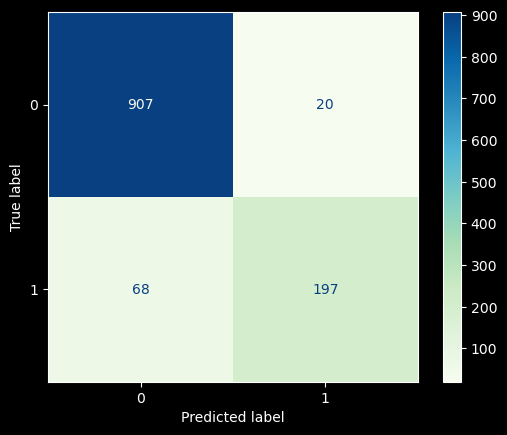

In [104]:
ConfusionMatrixDisplay.from_estimator(xgboost_bo, X_test, y_test, cmap='GnBu')
plt.show()

In [105]:
print('Precision: %.3f' % precision_score(y_test, bayesian_opt_predict))
print('Recall: %.3f' % recall_score(y_test, bayesian_opt_predict))
print('F1: %.3f' % f1_score(y_test, bayesian_opt_predict))
print('Accuracy: %.3f' % accuracy_score(y_test, bayesian_opt_predict))

Precision: 0.908
Recall: 0.743
F1: 0.817
Accuracy: 0.926


## XGBoost Optuna

In [106]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
    }

    # Fit the model
    optuna_model = XGBClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [107]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [108]:
study = optuna.create_study(direction='maximize',study_name='XGBoost_optuna')

In [109]:
study.optimize(objective, n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [110]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


Number of finished trials: 100
Best trial:
  Value: 0.9303691275167785
  Params: 
    max_depth: 9
    learning_rate: 0.2700377185592308
    n_estimators: 368
    min_child_weight: 1
    gamma: 0.8234090476639971
    subsample: 0.8651413920123883
    colsample_bytree: 0.33718878067455393
    reg_alpha: 0.8715588696345515
    reg_lambda: 0.7959932702510072


In [111]:
trial.params

{'max_depth': 9,
 'learning_rate': 0.2700377185592308,
 'n_estimators': 368,
 'min_child_weight': 1,
 'gamma': 0.8234090476639971,
 'subsample': 0.8651413920123883,
 'colsample_bytree': 0.33718878067455393,
 'reg_alpha': 0.8715588696345515,
 'reg_lambda': 0.7959932702510072}

/tmp/ipykernel_26592/2122237422.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study);


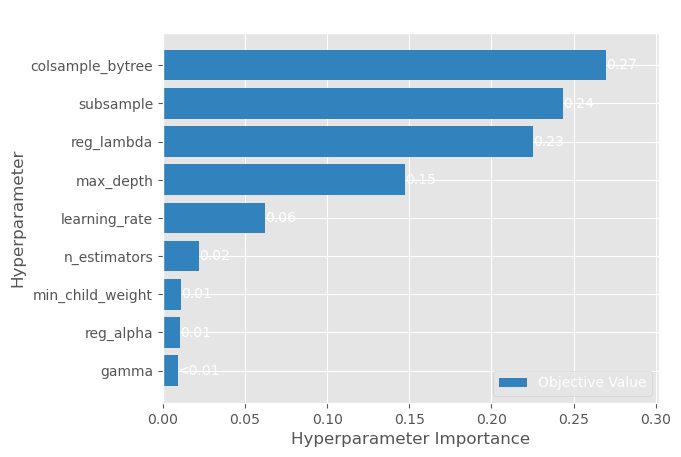

In [112]:
plot_param_importances(study);

In [113]:
params = trial.params

In [114]:
trial.params

{'max_depth': 9,
 'learning_rate': 0.2700377185592308,
 'n_estimators': 368,
 'min_child_weight': 1,
 'gamma': 0.8234090476639971,
 'subsample': 0.8651413920123883,
 'colsample_bytree': 0.33718878067455393,
 'reg_alpha': 0.8715588696345515,
 'reg_lambda': 0.7959932702510072}

In [115]:
xgb_model_5 = XGBClassifier(**params)

In [116]:
xgb_model_5.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.33718878067455393, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.8234090476639971,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2700377185592308,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=368, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [117]:
y_pred5 = xgb_model_5.predict(X_test)

In [118]:
accuracy = accuracy_score(y_test, y_pred5)
print("Accuracy after tuning: %.2f%%" % (accuracy * 100.0))

Accuracy after tuning: 93.04%


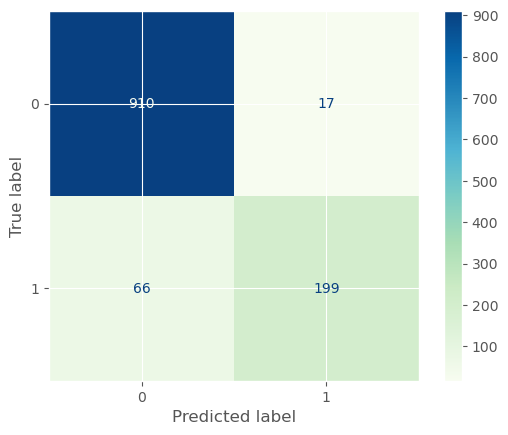

In [119]:
ConfusionMatrixDisplay.from_estimator(xgb_model_5, X_test, y_test, cmap='GnBu')
plt.show()

In [120]:
print('Precision: %.3f' % precision_score(y_test, y_pred5))
print('Recall: %.3f' % recall_score(y_test, y_pred5))
print('F1: %.3f' % f1_score(y_test, y_pred5))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred5))

Precision: 0.921
Recall: 0.751
F1: 0.827
Accuracy: 0.930


# Catboost

## catboost default param

In [121]:
params = {'verbose':100,
          'random_seed':42,
         }

In [122]:
cbt_model_1 = CatBoostClassifier(**params)

In [123]:
cbt_model_1.fit(
          X_train,
          y_train,
          eval_set=[(X_test, y_test)],
)

Learning rate set to 0.046608
0:	learn: 0.6504906	test: 0.6519643	best: 0.6519643 (0)	total: 50.3ms	remaining: 50.2s
100:	learn: 0.2239245	test: 0.2593794	best: 0.2593794 (100)	total: 259ms	remaining: 2.3s
200:	learn: 0.1759361	test: 0.2277054	best: 0.2277054 (200)	total: 460ms	remaining: 1.83s
300:	learn: 0.1389615	test: 0.2080768	best: 0.2080768 (300)	total: 667ms	remaining: 1.55s
400:	learn: 0.1148041	test: 0.1937774	best: 0.1937771 (398)	total: 899ms	remaining: 1.34s
500:	learn: 0.0964976	test: 0.1842703	best: 0.1842703 (500)	total: 1.15s	remaining: 1.14s
600:	learn: 0.0809795	test: 0.1758851	best: 0.1757541 (599)	total: 1.35s	remaining: 895ms
700:	learn: 0.0695926	test: 0.1692016	best: 0.1692016 (700)	total: 1.55s	remaining: 662ms
800:	learn: 0.0589859	test: 0.1634157	best: 0.1634157 (800)	total: 1.75s	remaining: 435ms
900:	learn: 0.0496015	test: 0.1575734	best: 0.1574931 (896)	total: 1.96s	remaining: 215ms
999:	learn: 0.0439474	test: 0.1543826	best: 0.1543826 (999)	total: 2.16s	r

In [124]:
y_pred_cbt_1 = cbt_model_1.predict(X_test)

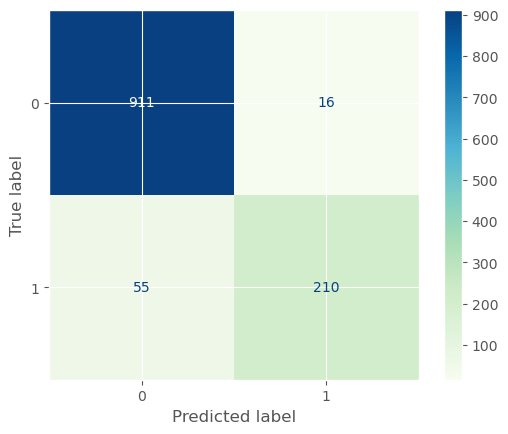

In [125]:
ConfusionMatrixDisplay.from_estimator(cbt_model_1, X_test, y_test, cmap='GnBu')
plt.show()

In [126]:
print('Precision: %.3f' % precision_score(y_test, y_pred_cbt_1))
print('Recall: %.3f' % recall_score(y_test, y_pred_cbt_1))
print('F1: %.3f' % f1_score(y_test, y_pred_cbt_1))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred_cbt_1))

Precision: 0.929
Recall: 0.792
F1: 0.855
Accuracy: 0.940


## cbt model 2

In [127]:
parameters = {
    'iterations':15000,
    'verbose':300,
    'od_type' : "Iter",
    'od_wait' : 500,
    'random_seed':42
}

In [128]:
model_cbt_2 = CatBoostClassifier(**parameters)

In [129]:
model_cbt_2.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
)

Learning rate set to 0.01435
0:	learn: 0.6796587	test: 0.6801356	best: 0.6801356 (0)	total: 3.38ms	remaining: 50.8s
300:	learn: 0.2296361	test: 0.2605449	best: 0.2605449 (300)	total: 663ms	remaining: 32.4s
600:	learn: 0.1811129	test: 0.2293839	best: 0.2293839 (600)	total: 1.28s	remaining: 30.6s
900:	learn: 0.1468474	test: 0.2091762	best: 0.2091762 (900)	total: 1.89s	remaining: 29.6s
1200:	learn: 0.1200607	test: 0.1937030	best: 0.1937030 (1200)	total: 2.51s	remaining: 28.8s
1500:	learn: 0.1017123	test: 0.1840267	best: 0.1840267 (1500)	total: 3.12s	remaining: 28s
1800:	learn: 0.0865927	test: 0.1754087	best: 0.1754087 (1800)	total: 3.73s	remaining: 27.4s
2100:	learn: 0.0746479	test: 0.1701184	best: 0.1700933 (2099)	total: 4.34s	remaining: 26.7s
2400:	learn: 0.0645251	test: 0.1651657	best: 0.1651257 (2399)	total: 4.96s	remaining: 26s
2700:	learn: 0.0563117	test: 0.1610527	best: 0.1610238 (2696)	total: 5.57s	remaining: 25.4s
3000:	learn: 0.0493795	test: 0.1577020	best: 0.1577020 (3000)	tota

In [130]:
y_pred_cbt_2 = model_cbt_2.predict(X_test)

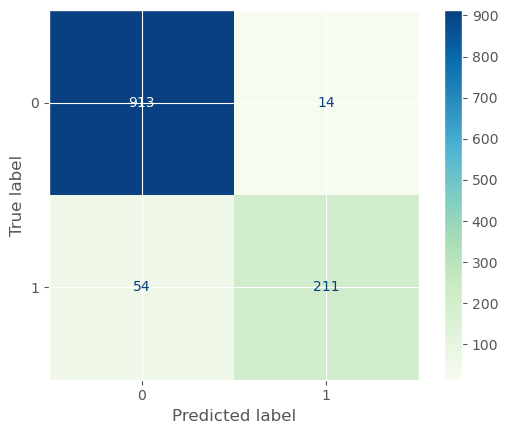

In [131]:
ConfusionMatrixDisplay.from_estimator(model_cbt_2, X_test, y_test, cmap='GnBu')
plt.show()

In [132]:
print('Precision: %.3f' % precision_score(y_test, y_pred_cbt_2))
print('Recall: %.3f' % recall_score(y_test, y_pred_cbt_2))
print('F1: %.3f' % f1_score(y_test, y_pred_cbt_2))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred_cbt_2))

Precision: 0.938
Recall: 0.796
F1: 0.861
Accuracy: 0.943


# Summary: 

In [133]:
result = { 'metrics':['Precision','Recall','F1','Accuracy'],
          'xgb_default_param':
              [0.905,
               0.758,
               0.825,
               0.929],
          'xgb_grid_search':
              [0.911,
               0.774,
               0.837,
               0.933],
           'xgb_random_search':
              [0.847,
               0.645,
               0.732,
               0.895],         
           'xgb_bo':
              [0.851,
               0.713,
               0.776,
               0.909],
           'xgb_optuna':
              [0.940,
               0.826,
               0.880,
               0.950],
           'cbt_default_param':
              [0.929,
               0.792,
               0.855,
               0.940],
           'cbt_littleBitTunned':
               [0.938,
                0.796,
                0.861,
                0.943]
}

In [134]:
result_df = pd.DataFrame.from_dict(result)
result_df.T

,0,1,2,3
metrics,Precision,Recall,F1,Accuracy
xgb_default_param,0.905,0.758,0.825,0.929
xgb_grid_search,0.911,0.774,0.837,0.933
xgb_random_search,0.847,0.645,0.732,0.895
xgb_bo,0.851,0.713,0.776,0.909
xgb_optuna,0.94,0.826,0.88,0.95
cbt_default_param,0.929,0.792,0.855,0.94
cbt_littleBitTunned,0.938,0.796,0.861,0.943
